In [1]:
import os
import pandas as pd
import numpy as np
import random

import zipfile
from urllib import request

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torchvision import transforms

In [2]:
class SeqDataset(Dataset):
    def __init__(self, user_ids, item_ids, L, num_users, num_items, candidates):
        user_ids, item_ids = np.array(user_ids), np.array(item_ids)
        sort_idx = np.array(sorted(range(len(user_ids)),
                                    key=lambda k: user_ids[k]))
        u_ids, i_ids = user_ids[sort_idx], item_ids[sort_idx]
        temp, u_ids, self.cand = {}, np.array(u_ids), candidates
        self.all_items = set([i for i in range(num_items)])
        [temp.setdefault(u_ids[i], []).append(i) for i, _ in enumerate(u_ids)]
        temp = sorted(temp.items(), key=lambda x: x[0])
        u_ids = np.array([i[0] for i in temp])
        idx = np.array([i[1][0] for i in temp])
        self.ns = ns = int(sum([c - L if c >= L + 1 else 1 for c
                                in np.array([len(i[1]) for i in temp])]))
        self.seq_items = np.zeros((ns, L))
        self.seq_users = np.zeros(ns, dtype='int32')
        self.seq_tgt = np.zeros((ns, 1))
        self.test_seq = np.zeros((num_users, L))
        test_users, _uid = np.empty(num_users), None
        for i, (uid, i_seq) in enumerate(self._seq(u_ids, i_ids, idx, L + 1)):
            if uid != _uid:
                self.test_seq[uid][:] = i_seq[-L:]
                test_users[uid], _uid = uid, uid
            self.seq_tgt[i][:] = i_seq[-1:]
            self.seq_items[i][:], self.seq_users[i] = i_seq[:L], uid

    def _win(self, tensor, window_size, step_size=1):
        if len(tensor) - window_size >= 0:
            for i in range(len(tensor), 0, - step_size):
                if i - window_size >= 0:
                    yield tensor[i - window_size:i]
                else:
                    break
        else:
            yield tensor

    def _seq(self, u_ids, i_ids, idx, max_len):
        for i in range(len(idx)):
            stop_idx = None if i >= len(idx) - 1 else int(idx[i + 1])
            for s in self._win(i_ids[int(idx[i]):stop_idx], max_len):
                yield (int(u_ids[i]), s)

    def __len__(self):
        return self.ns

    def __getitem__(self, idx):
        neg = list(self.all_items - set(self.cand[int(self.seq_users[idx])]))
        i = random.randint(0, len(neg) - 1)
        # user id, time step 만큼의 items, target item, neg item
        return (int(self.seq_users[idx]), torch.tensor(self.seq_items[idx]), int(self.seq_tgt[idx][0]),
                neg[i])

In [3]:
def download_ml100k():
    # download
    url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
    savename = "ml-100k.zip"
    request.urlretrieve(url, savename)
    print('Complete!')
    # unzip
    file_name = os.path.join('./', savename)
    file_zip = zipfile.ZipFile(file_name)
    file_zip.extractall('./')
    file_zip.close()

def read_data_ml100k():
    """
    데이터를 다운받고, dataframe형태의 data, user id목록, itme id 목록 반환
    """
    if not os.path.isfile(os.path.join('./ml-100k/', 'u.data')):
        print('Download ...')
        download_ml100k()
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join('./ml-100k/', 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [4]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    """
    과정은 정확히 이해안되는데 user id, item id, score, 유저-아이템 행렬 반환
    explicit 일때는 유저 아이템 행렬
    implicit 일때는 key : 유저, val : 아이템 리스트 인 dict 
    """
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [5]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

In [6]:
TARGET_NUM, L, batch_size = 1, 5, 4096
df, num_users, num_items = read_data_ml100k()
train_data, test_data = split_data_ml100k(df, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
users_test, items_test, ratings_test, test_candidates = load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")

C:\Users\jiwoo\AppData\Local\Temp\ipykernel_19460\3207216276.py:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df, num_users, num_items = read_data_ml100k()


In [32]:
train_seq_data = SeqDataset(users_train, items_train, L, num_users,
                            num_items, candidates)
train_iter = DataLoader(train_seq_data, batch_size, drop_last=True)
test_seq_iter = train_seq_data.test_seq

# user id, time step 만큼의 items, target item, neg item
train_seq_data[0]

(0, tensor([241., 170., 110., 255.,   4.], dtype=torch.float64), 101, 1268)

In [38]:
from torch.nn import Conv2d
class Caser(nn.Module):
    def __init__(self, num_factors, num_users, num_items, L=5, d=16, # num_factors == k
                 d_prime=4, drop_ratio=0.05, **kwargs): 
        super(Caser, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors) # user's general taste embedding
        self.Q = nn.Embedding(num_items, num_factors) # item embedding
        self.d_prime, self.d = d_prime, d # vertical / horizontal filter의 갯수
        # Vertical convolution layer
        self.conv_v = Conv2d(in_channels=1, out_channels=d_prime, kernel_size=(L, 1))
        # Horizontal convolution layer
        h = [i + 1 for i in range(L)]
        self.conv_h, self.max_pool = [], []
        for i in h:
            self.conv_h.append(nn.Conv2d(in_channels=1, out_channels=d, kernel_size=(i, num_factors)))
            self.max_pool.append(nn.MaxPool1d(kernel_size=(L - i + 1)))
        # print(self.conv_h)
        # print('-'*100)
        # print(self.conv_v)
        self.conv_h, self.conv_v = nn.Sequential(*self.conv_h), nn.Sequential(self.conv_v)
        
        # Fully-connected layer
        self.fc1_dim_v, self.fc1_dim_h = d_prime * num_factors, d * len(h) # output dim of vertical conv / horizontal conv
        self.fc = nn.Linear(in_features=d_prime * num_factors + d * L, out_features=num_factors) # input : concat of vertical/horzontal conv output, output : z
        self.relu = nn.ReLU()
        self.Q_prime = nn.Embedding(num_items, num_factors * 2) # another item embedding
        self.b = nn.Embedding(num_items, 1)
        self.dropout = nn.Dropout(drop_ratio)

    def forward(self, user_id, seq, item_id):
        item_embs = torch.unsqueeze(self.Q(seq), 1)
        user_emb = self.P(user_id)
        out, out_h, out_v, out_hs = None, None, None, []
        if self.d_prime:
            out_v = self.conv_v(item_embs)
            out_v = out_v.reshape(out_v.shape[0], self.fc1_dim_v)
        if self.d:
            for conv, maxp in zip(self.conv_h, self.max_pool):
                conv_out = torch.squeeze(self.relu(conv(item_embs)), dim=3)
                t = maxp(conv_out)
                pool_out = torch.squeeze(t, dim=2)
                out_hs.append(pool_out)
            out_h = torch.stack(out_hs, dim=1).view(batch_size,-1)
        # print(out_v.size(), out_h.size())
        out = torch.cat((out_v, out_h), dim=1)
        z = self.relu(self.fc(self.dropout(out)))
        x = torch.cat((z, user_emb), dim=1) # user_emb : user's general taste embedding
        q_prime_i = torch.squeeze(self.Q_prime(item_id))
        b = torch.squeeze(self.b(item_id))
        res = (x * q_prime_i).sum(1) + b
        return res

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Caser(num_factors=10, num_users=num_users, num_items=num_items)
model = model.to(device)

In [40]:
class BPRLoss(nn.Module):
    def __init__(self, **kwargs):
        super(BPRLoss, self).__init__(**kwargs)
        self.sigmoid = nn.Sigmoid()

    def forward(self, positive, negative):
        distances = positive - negative
        loss = - torch.sum(torch.log(self.sigmoid(distances)))
        return loss

In [41]:
lr, num_epochs, wd, optimizer = 0.01, 10, 1e-5, 'adam'

loss_func = BPRLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

In [42]:
from tqdm import tqdm
import glob
import os

train_epoch_loss = []
val_epoch_loss_lst = []
best_val_epoch_loss = int(1e9)
for epoch in tqdm(range(num_epochs)):
    train_iter_loss = []
    for i, values in enumerate(train_iter):
        p_pos = model(values[0].to(device), values[1].to(device).long(), values[2].to(device)) 
        p_neg = model(values[0].to(device), values[1].to(device).long(), values[3].to(device)) 
        loss = loss_func(p_pos, p_neg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_iter_loss.append(loss.detach().item())
        if i%50 == 0:
            print(f'{epoch} epoch {i}th train iter loss: {loss.detach().item()}')  
    train_epoch_loss.append(np.mean(train_iter_loss))
    print(f'{epoch} epoch ALL LOSS : ', np.mean(train_iter_loss))

    # with torch.no_grad():
    #     model.eval()
    #     val_epoch_loss = 0
    #     for i, values in enumerate(test_iter):
    #         p_pos = model(values[0].to(device), values[1].to(device), values[2].to(device)) 
    #         p_neg = model(values[0].to(device), values[1].to(device), values[3].to(device)) 
    #         loss = loss_func(p_pos, p_neg)
    #         val_epoch_loss += loss.detach().item()
    #     val_epoch_loss /= len(test_iter)
    #     val_epoch_loss_lst.append(val_epoch_loss)

    # if val_epoch_loss < best_val_epoch_loss:
    #     best_val_epoch_loss = val_epoch_loss
    #     print(f'New best model loss: {best_val_epoch_loss}')
    #     if not os.path.exists('ncf_model'):
    #         os.mkdir('ncf_model')

    #     if os.path.exists('ncf_model/best.pth'):
    #         os.remove('ncf_model/best.pth')
    #         torch.save(model.state_dict(), 'ncf_model/best.pth')
    #         print('best model is saved!')

    

  0%|          | 0/10 [00:00<?, ?it/s]

0 epoch 0th train iter loss: 7992.8701171875


 10%|█         | 1/10 [00:06<01:02,  6.99s/it]

0 epoch ALL LOSS :  7141.98972486413
1 epoch 0th train iter loss: 6453.3359375


 20%|██        | 2/10 [00:13<00:53,  6.72s/it]

1 epoch ALL LOSS :  5930.71531080163
2 epoch 0th train iter loss: 5393.2509765625


 30%|███       | 3/10 [00:19<00:45,  6.53s/it]

2 epoch ALL LOSS :  4893.648554262908
3 epoch 0th train iter loss: 4621.61474609375


 40%|████      | 4/10 [00:26<00:38,  6.46s/it]

3 epoch ALL LOSS :  4023.4557468580165
4 epoch 0th train iter loss: 3756.32421875


 50%|█████     | 5/10 [00:32<00:32,  6.41s/it]

4 epoch ALL LOSS :  3291.258247707201
5 epoch 0th train iter loss: 3117.317626953125


 60%|██████    | 6/10 [00:38<00:25,  6.34s/it]

5 epoch ALL LOSS :  2839.376857591712
6 epoch 0th train iter loss: 2885.0107421875


 70%|███████   | 7/10 [00:45<00:19,  6.40s/it]

6 epoch ALL LOSS :  2472.299762228261
7 epoch 0th train iter loss: 2388.111572265625


 80%|████████  | 8/10 [00:51<00:13,  6.51s/it]

7 epoch ALL LOSS :  2218.8202381963315
8 epoch 0th train iter loss: 2265.22021484375


 90%|█████████ | 9/10 [00:59<00:06,  6.75s/it]

8 epoch ALL LOSS :  2056.2130180027175
9 epoch 0th train iter loss: 2089.041748046875


100%|██████████| 10/10 [01:06<00:00,  6.62s/it]

9 epoch ALL LOSS :  1903.8975193189538


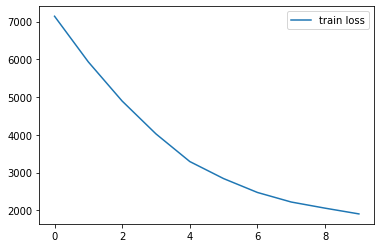

In [43]:
import matplotlib.pyplot as plt

plt.plot(train_epoch_loss, label='train loss')

# plt.plot(val_epoch_loss_lst, label='val loss')
plt.legend()